`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools

In [2]:
xrootdstr = 'root://cmseos.fnal.gov//'

In [3]:
qcdfilename = 'flatqcd.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr + s.strip() for s in f.readlines()]

In [5]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [22]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ b+y for b,y in itertools.product( self.btagcats, self.ycats) ]
        self.anacats += ['pretag']
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        ht_axis = hist.Bin("h_ak4ht", r"AK4 Jet H_{T} [GeV]", 50, 0, 5000)
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        jetn3b1_axis = hist.Bin("n3b1", r"Jet N3", 50, 0, 1)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        

        self._accumulator = processor.dict_accumulator({
            'h_ak4ht'  : hist.Hist("Counts", dataset_axis, cats_axis, ht_axis),
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB']
            )
        
        #weight = JaggedArray.fromcounts(
        #    np.ones_like(df['Generator_binvar'],dtype=int),
        #    df['Generator_weight']
        #)
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += FatJets.size

        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()
        
        jet_id = (FatJets.jetId > 0)
        
        #print("jet_id[:,0]", jet_id[:,0])          
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5)
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()
        
        evtweights = evtweights[twoFatJets]
        ttbarcands = FatJets[:,0:2].distincts()

        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]

        
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut]        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        # Now get the analysis categories. 
        # They are (central, forward)   cross   (0b,1b,>=2b)
        cen = np.abs(ttbarcands.i0.p4.y - ttbarcands.i1.p4.y) < 1.0
        fwd = np.logical_not(cen)
        
        btag_i0 = (ttbarcands.i0.btagDeepB > 0.7)
        btag_i1 = (ttbarcands.i1.btagDeepB > 0.7)
        
        btag0 = np.logical_not(btag_i0) & np.logical_not(btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        cat0 = (cen & btag0).flatten()
        cat1 = (fwd & btag0).flatten()
        cat2 = (cen & btag1).flatten()
        cat3 = (fwd & btag1).flatten()
        cat4 = (cen & btag2).flatten()
        cat5 = (fwd & btag2).flatten()
        pretag = [True] * len(cen)
        cats = [cat0,cat1,cat2,cat3,cat4,cat5,pretag]
        
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        
        for ilabel,icat in labels_and_categories.items():
            output['cutflow'][ilabel] += np.sum(icat)
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=evtweights[icat].flatten())

        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [32]:
tstart = time.time()

fileset = {
    'TTbar':ttbarfiles,
    #'QCD':qcdfiles # QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8
    #'ZZ to 4mu': [
    #    'data/ZZTo4mu.root'
    #]
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(),
                                  executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'workers': 4},
                                  chunksize=50000
                                 )

elapsed = time.time() - tstart
print(output)

['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd', 'pretag']
{'h_ak4ht': <Hist (dataset,anacat,h_ak4ht) instance at 0x7fb8d9f48250>, 'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fb8d9f48050>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fb8d9f48150>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fb8da291310>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 142155064, 'two FatJets': 16168332, 'jet id': 16166044, 'jet kin': 2945971, '>= one oneTTbar': 1004923, 'dPhi > 2.1': 496677, '0bcen': 209, '0bfwd': 361605, '1bcen': 79, '1bfwd': 125282, '2bcen': 4, '2bfwd': 9498, 'pretag': 496677})}


In [25]:
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,.5)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}


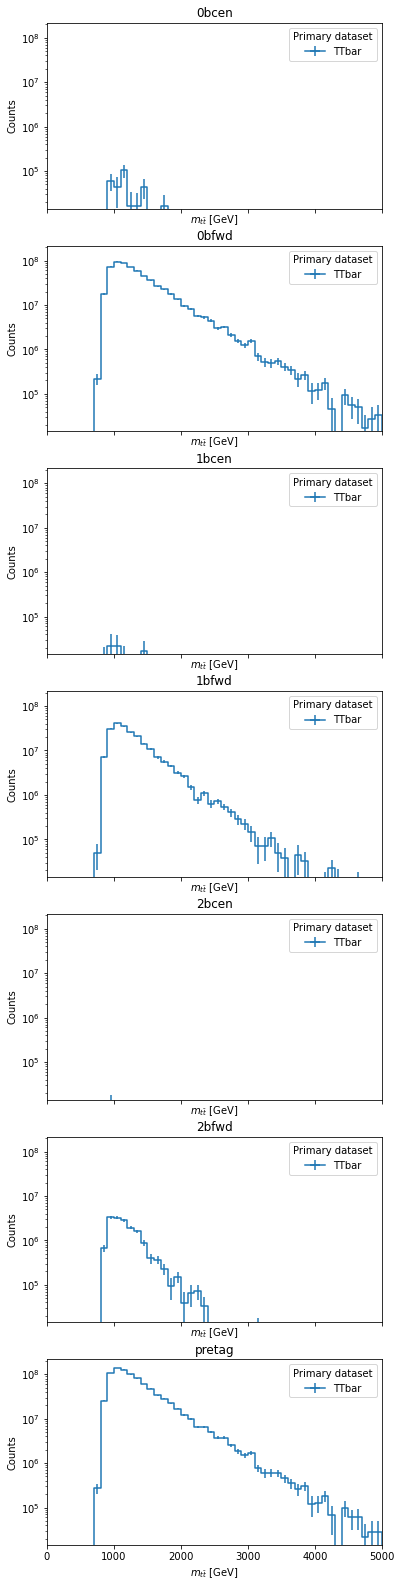

In [28]:
import matplotlib.pyplot as plt
ax = hist.plotgrid(output['ttbarmass'], row="anacat", overlay="dataset", #stack=True,
                                  #fill_opts=stack_fill_opts,
                                  #error_opts=stack_error_opts,
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
#fig.show()

In [29]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 402183.7438137832


In [30]:
for i,j in output['cutflow'].items():
    print( '%20s : %12d' % (i,j) )

          all events :    142155064
         two FatJets :     16168332
              jet id :     16166044
             jet kin :      2945971
     >= one oneTTbar :      1004923
          dPhi > 2.1 :       496677
               0bcen :          209
               0bfwd :       361605
               1bcen :           79
               1bfwd :       125282
               2bcen :            4
               2bfwd :         9498
              pretag :       496677


In [ ]:

#mapping = {
#    'QCD': ['QCD'],
#}
#output['ttbarmass'].group("dataset", hist.Cat("dataset", "dataset"), mapping)
#hist_noDS = output['ttbarmass_pretag'].integrate('dataset')
